Import packages and functions

In [33]:
import sys
sys.path.append('../../../')



import numpy as np
import matplotlib.pyplot as plt
from scripts.forecast import FisherMatrix
import seaborn as sns
import scipy.interpolate as interpolate
import pandas as pd
from scripts.utils import  set_mpl, path2plots, path2res_forecast
set_mpl()

set palette to pastel
set matplotlib rc


Define the photo-z properties and plotting style

In [34]:

sigmas_clu = np.array([0.3, 0.2, 0.1,   0.07, 0.05,
                       0.03, 0.02, 0.015, 0.01, 0.005])
f_fails_clu = np.array([0.01, 0.02, 0.05,  0.1, 0.2])


sigmas_agn = np.array([0.3, 0.2, 0.1,   0.07, 0.05,
                       0.03, 0.02, 0.015])
f_fails_agn = np.array([0.01, 0.02, 0.05,  0.1, 0.2])



corner_plot_args = {'linewidths': [1.5, 1.5, 2], 'shade': True,  'shade_alpha': 0.4, 'sigmas': [1], 'label_font_size': 20, 'tick_font_size': 15, 'colors': sns.color_palette('pastel').as_hex(), 
'linestyles': ['--', '--', '-'], 'legend_kwargs':{'title':r'Tracer ($\sigma_0$; $f_{{\rm fail}}$)', 'fontsize': 15}}

%matplotlib inline
savepath = path2res_forecast + 'cosmo-photoz/'


Load the results of the previous script

In [35]:
def load_fisher_sigma0_f_fail(sigma_0, f_fail,):
    setname_clu = f'Clusters_{sigma_0}_{f_fail}'
    fname_clu = savepath + f'{setname_clu}.npz'
    setname_agn = f'AGN_{sigma_0}_{f_fail}'
    fname_agn = savepath + f'{setname_agn}.npz'
    Fs = []
    for fname, setname in zip([fname_clu, fname_agn], [setname_clu, setname_agn]):
        try:
            arr = np.load(fname, allow_pickle=True)
            pars = arr['pars']
            par_names = arr['par_names']
            F = arr['F']
            J = arr['J']
            comp=setname.split('_')
            Fname = f'{comp[0]}({comp[1]},{comp[2]})'
            F = FisherMatrix(par=pars, par_names=par_names, F=F,
                                J=J, name=Fname, function=lambda x: x)
            F = F.transform_to_Om()
            #F.check_derivatives()
            Fs.append(F)
        except FileNotFoundError:
            #print(f'{fname} not found')
            Fs.append(None)
    return Fs



In [36]:
Fs = []
idx = 0
res = []
for sigma_0 in sigmas_clu:
    for f_fail in f_fails_clu:
        Fs_tmp = load_fisher_sigma0_f_fail(sigma_0, f_fail)
        res.append({'sigma_0': sigma_0, 'f_fail': f_fail, 'F_agn': Fs_tmp[1], 'F_clu': Fs_tmp[0]})
        Fs.append([Fs_tmp[0], Fs_tmp[1]])
        idx += 1
df_cosmo = pd.DataFrame(res)

In [37]:

pessimistic_agn_id = 18
conservative_agn_id =  23
optimistic_agn_id =  28

pessimistic_clu_id = 32
conservative_clu_id = 41
optimistic_clu_id = 45



make a fucntion for interpolation on a grid

In [38]:


def cosmo_significance(si, fi, type: str='AGN',):
    """
    cosmo_significance returns the value of Figure of Merit for a given sigma_0 and f_fail

    Args:
        si (float): sigma_0
        fi (float): f_fail
        type (str, optional): type of tracer. Defaults to 'AGN'.
        factor (int, optional): factor to multyply Fisher matrix by. Defaults to 1.


    Returns:
        FoM 
    """


    # to compare with huetsi2014 use factor np.sqrt(1/(0.658) (to make f_sky = 1)

    if type == 'AGN':
        F =  df_cosmo.query('(f_fail == @fi) & (sigma_0 == @si)')['F_agn'].values[0]
    elif type == 'Clusters':
        F = df_cosmo.query('(f_fail == @fi) & (sigma_0 == @si)')['F_clu'].values[0]
    else:
        raise ValueError(f'Type {type} not recognized')
    
    cov = np.linalg.inv(F.F)
    FoM = np.pi/np.sqrt(np.linalg.det(cov))
    return np.log10(FoM)



A long boring function to plots Figure of Merit as a function of `sigma_0`, `f_fail` as I want

In [39]:
set_mpl()


def plot_results(type='AGN',   cmap='GnBu'):
    if type == 'AGN':
        sigmas = sigmas_agn
        f_fails = f_fails_agn
    else:
        sigmas = sigmas_clu
        f_fails = f_fails_clu


    plt.rcParams['axes.grid'] = False

    points = []
    values = []
    for sigma_0 in sigmas:
        for f_fail in f_fails:
            points.append((sigma_0, f_fail))
            values.append(cosmo_significance(sigma_0, f_fail, type = type))
    
    points = np.array(points)
    values = np.array(values)

    axis_sigma = np.geomspace(sigmas.min(), sigmas.max(), 50)
    axis_f_fail = np.geomspace(f_fails.min(), f_fails.max(), 50)
    xx,yy = np.meshgrid(axis_sigma, axis_f_fail)
    result = interpolate.griddata(points, values, (xx,yy), method='linear')



    fig1 = plt.figure(figsize=(15, 10))
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.5)
    rows, cols = 2, 5
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax = plt.subplot2grid((rows, cols), (0, 0), rowspan=2, colspan=3)
    ax_slice1 = plt.subplot2grid((rows, cols), (0, 3), rowspan=1, colspan=2)
    ax_slice2 = plt.subplot2grid((rows, cols), (1, 3), rowspan=1, colspan=2)

    im2 = ax.pcolormesh(xx, yy, result, cmap=cmap)
    cp = ax.contour(xx, yy, result, 10, colors=[
                    'k'], linestyles='-.', linewidths=2, alpha=0.5)
    ax.clabel(cp, inline=1, fontsize=15, fmt='%1.2f')
    cbar = fig1.colorbar(im2, ax=ax)
    cbar.set_label('FoM', rotation=90, labelpad=20)


    for f_fail in f_fails:
        sign_axis = [cosmo_significance(s, f_fail, type=type) for s in sigmas]

        ax_slice1.loglog(sigmas, sign_axis, '-.', lw=3,
                         alpha=0.8, label=f'{f_fail}')
        ax_slice1.set_xlabel(r'$\sigma_0$')
        ax_slice1.legend(fontsize=15, title=r'$f_{\rm fail}$', loc=(1.04, 0.4))

    for sigma in sigmas:
        sign_axis = [cosmo_significance(sigma, f, type=type) for f in f_fails]
        ax_slice2.semilogx(f_fails, sign_axis, '-.', lw=3,
                           alpha=0.8, label=f'{sigma}')
        ax_slice2.set_xlabel(r'$f_{\rm fail}$')
        ax_slice2.legend(fontsize=15, title=r'$\sigma_0$', loc=(1.04, 0.4))


    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\sigma_0$')
    ax.set_ylabel(r'$f_{\rm fail}$')
    ax.set_title('FoM' + f', {type}; ' + r"$f_{\rm sky}$" + '=0.658')
    ax.set_xlim(0.004, 0.21)
    ax.set_ylim(0.009, 0.21)
    ax.set_xticks([0.005, 0.01, 0.02, 0.03, 0.04,
                   0.05, 0.06, 0.07, 0.1, 0.2, 0.3])
    ax.set_xticks(ax.get_xticks()[::1])


    return points, values, 



set palette to pastel
set matplotlib rc


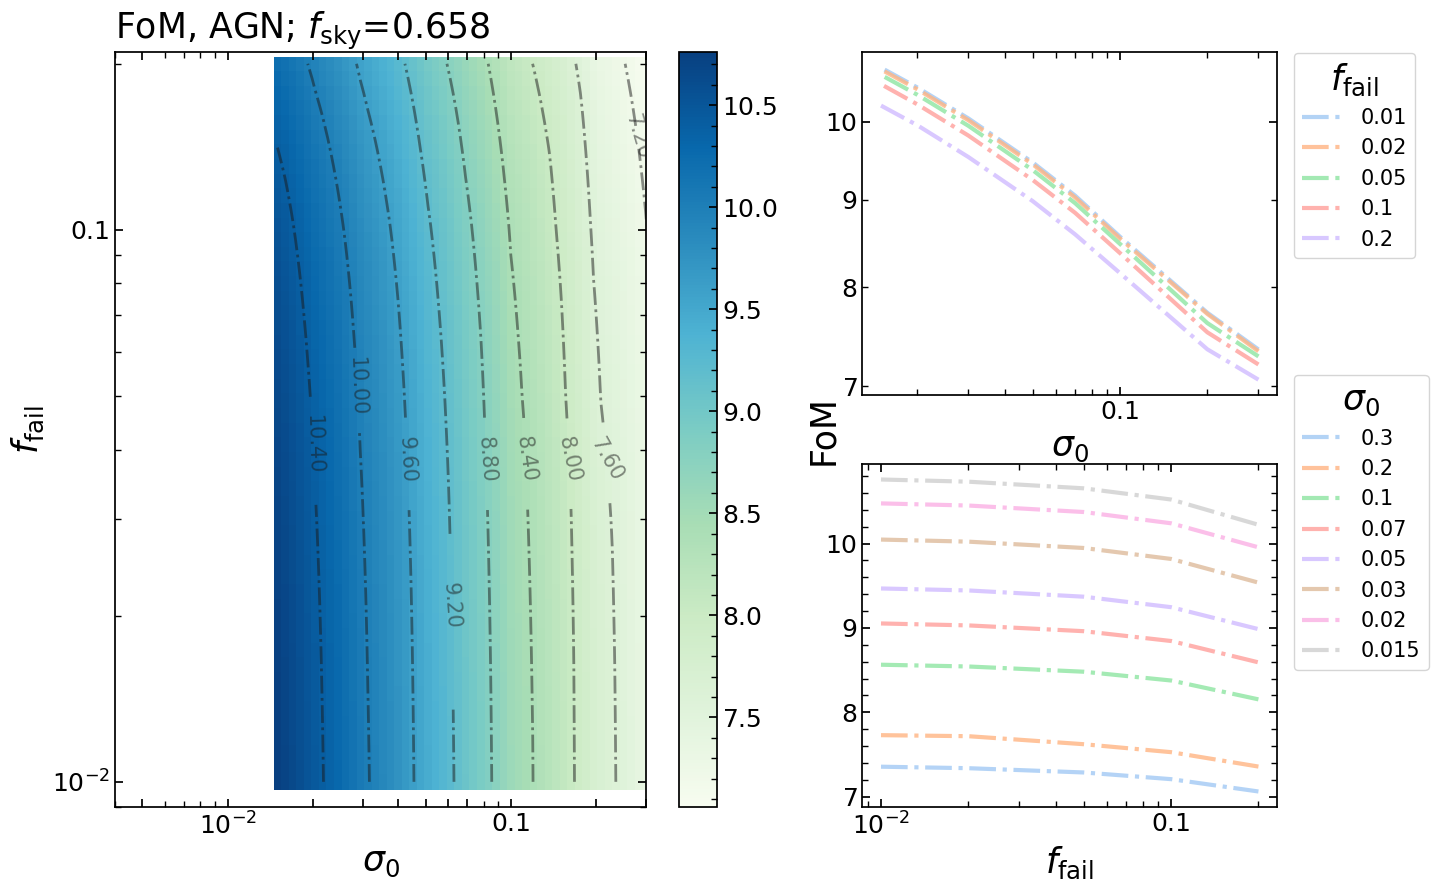

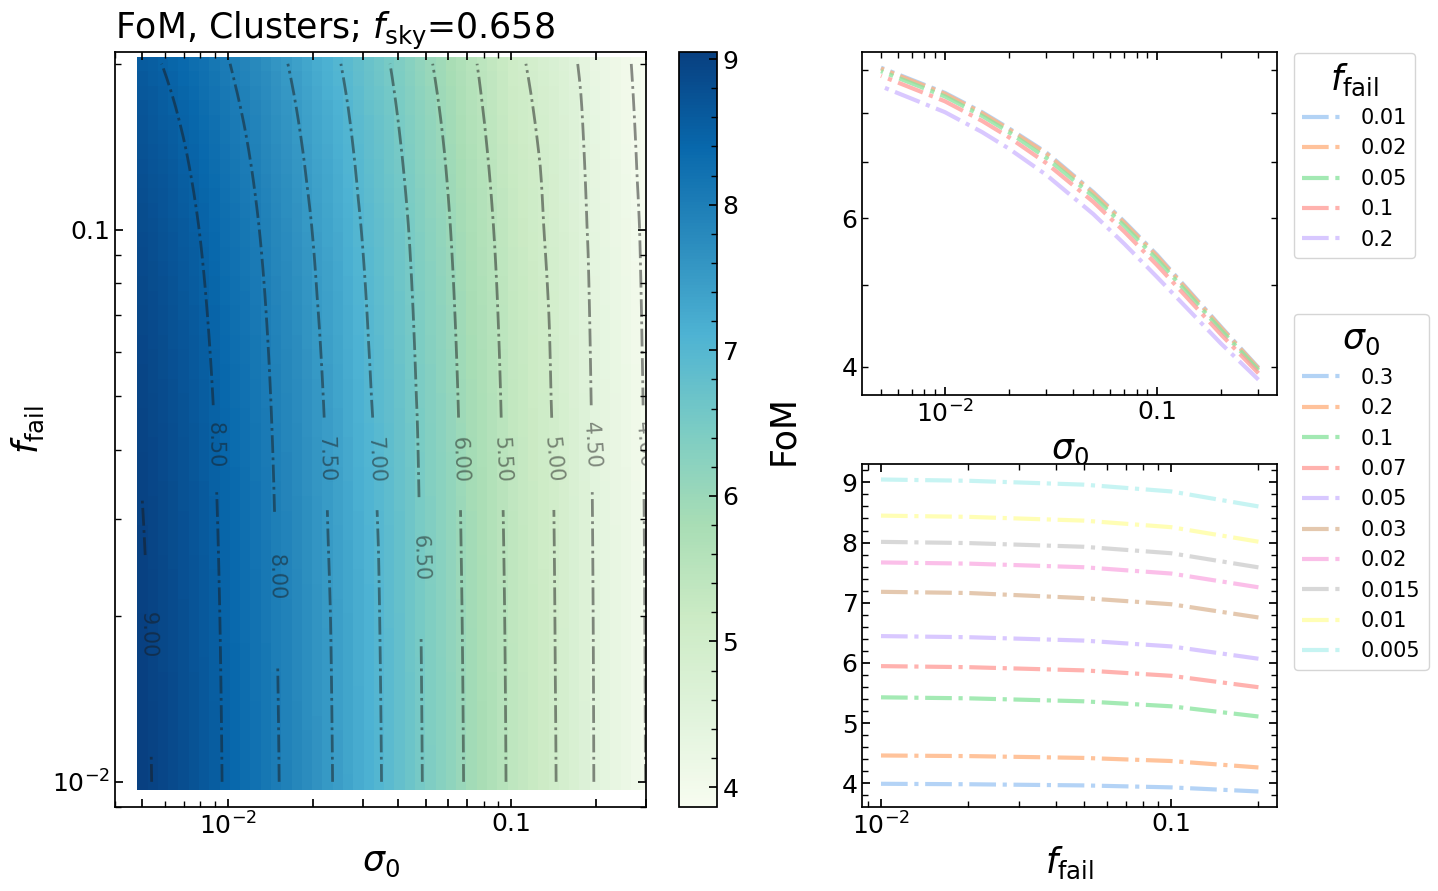

In [40]:
plot_results(cmap = 'GnBu');
plt.savefig(f'{path2plots}/cosmo_forecast/photoz-cosmo_agn.pdf')

plot_results(type = 'Clusters',cmap = 'GnBu');
plt.savefig(f'{path2plots}/cosmo_forecast/photoz-cosmo_clu.pdf')


In [21]:
# idx = 0
# for sigma_0 in sigmas_all:
#     for f_fail in f_fails_all:
#         F = load_fisher_sigma0_f_fail(sigma_0, f_fail)
#         cond1 = ~F[0].check_derivatives(title = F[0].name)
#         try:
#             cond2 = ~F[1].check_derivatives(title = F[1].name)
#         except:
#             cond2 = False
#         if cond1 or cond2:
#             print(f'====== {sigma_0=} {f_fail=}, index = {idx} ====')
#         idx += 1
